# 图像分类数据集Fashion-MNIST

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import d2lzh as d2l

- d2l是《动手学习深度学习》的配套库；
- d2lzh是该书代码中文版。

In [2]:
display.set_matplotlib_formats("svg")
plt.rcParams["figure.figsize"] = (4,4)

我这里我们会使用torchvision包，它是服务于PyTorch深度学习框架的，主要用来构建计算机视觉模型。torchvision主要由以下几部分构成：
1. torchvision.datasets: 一些加载数据的函数及常用的数据集接口；
2. torchvision.models: 包含常用的模型结构（含预训练模型），例如:
    - AlexNet
    - VGG
    - ResNet
3. torchvision.transforms: 常用的图片变换，例如裁剪、旋转等；
4. torchvision.utils: 其他的一些有用的方法。

## 计算机视觉框架torchvision

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
print(torch.__version__)
print(torch.cuda.is_available())
print(torchvision.__version__)

1.0.0
True
0.2.2


### 下载数据

In [4]:
mnist_train = torchvision.datasets.FashionMNIST(root="./FashionMNIST2065", 
                                                train=True, 
                                                download=True, 
                                                transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root="./FashionMNIST2065", 
                                               train=False, 
                                               download=True, 
                                               transform=transforms.ToTensor())

### 数据集信息

In [5]:
print(type(mnist_train))
print(type(mnist_train[0]))

<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'tuple'>


In [6]:
print(len(mnist_train), len(mnist_test))

60000 10000


In [7]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


In [8]:
mnist_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 图像示例

In [9]:
def get_fashion_mnist_labels(ilabels):
    text_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return [text_labels[int(i)] for i in ilabels]

In [10]:
def show_fashion_mnist(images, labels):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(8,4))
    for ax, img, lbl in zip(axes.flatten(), images, labels):
        ax.imshow(img.view(28,28).numpy())
        ax.set_title(lbl)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.tight_layout()

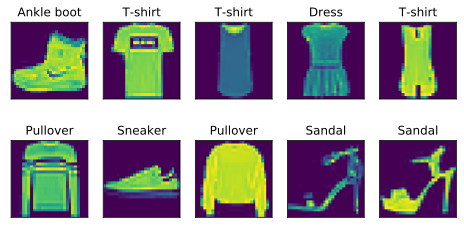

<Figure size 288x288 with 0 Axes>

In [11]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

### 准备数据集

In [12]:
batch_size = 256
num_workers = 4

In [13]:
train_iter_torch = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True)
test_iter_torch = torch.utils.data.DataLoader(mnist_test, 
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True)

In [14]:
start = time.time()
for X, y in train_iter_torch:
    continue
print('%.2f sec' % (time.time() - start))

2.58 sec


## softmax从零开始实现

In [15]:
# d2l.load_data_fashion_mnist??

In [16]:
num_inputs = 28*28
num_outputs = len(mnist_train.classes)
num_epochs = 5
lr = 0.1

### 模型参数初始化

In [17]:
W = torch.tensor(np.random.normal(0,0.01,size=(num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

In [18]:
W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

In [19]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 定义模型

In [20]:
def softmax_torch(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    # torch.Tensor().sum()
    return X_exp/partition

In [21]:
X = torch.rand((2,5))
X_prob = softmax_torch(X)
print(X_prob,"\n",X_prob.sum(dim=1))

tensor([[0.2137, 0.2329, 0.1954, 0.2057, 0.1524],
        [0.2598, 0.1698, 0.1611, 0.2573, 0.1520]]) 
 tensor([1.0000, 1.0000])


In [22]:
def net_torch(X):
    num_inputs = W.shape[0]
    return softmax_torch(torch.mm(X.view(-1, num_inputs), W)+b)

In [23]:
for X, y in train_iter_torch:
    break
net_torch(X).shape

torch.Size([256, 10])

### 定义损失函数

*gather(dim, index) → Tensor*

In [24]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1,1)))

In [25]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])

In [26]:
cross_entropy(y_hat, y)

tensor([[2.3026],
        [0.6931]])

In [27]:
-np.log(0.1), -np.log(0.5)

(2.3025850929940455, 0.6931471805599453)

In [28]:
for X, y in train_iter_torch:
    break
cross_entropy(net_torch(X),y).sum().item()

589.1483154296875

### 定义优化函数

In [29]:
def sgd_torch(params, lr):
    for param in params:
        param.data -= lr*param.grad / batch_size

### 定义指标：准确率

In [30]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1)==y).float().mean().item()

In [31]:
for X, y in train_iter_torch:
    break
accuracy(net_torch(X),y)

0.140625

In [32]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

In [33]:
evaluate_accuracy(test_iter_torch,net_torch)

0.1336

### 训练模型

In [34]:
for epoch in range(1, num_epochs+1):
    train_l_sum, train_acc_sum,n = 0.0,0.0,0
    for X, y in train_iter_torch:
        y_hat = net_torch(X)
        l = cross_entropy(y_hat,y).sum()
        l.backward()
        sgd_torch([W,b], lr)
        W.grad.data.zero_()
        b.grad.data.zero_()
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter_torch,net_torch)
    print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.4f}, test_acc {:.4f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, train_loss 0.7849, train_acc_sum 0.7514, test_acc 0.7908
epoch 2, train_loss 0.5702, train_acc_sum 0.8122, test_acc 0.8111
epoch 3, train_loss 0.5254, train_acc_sum 0.8256, test_acc 0.8117
epoch 4, train_loss 0.5008, train_acc_sum 0.8318, test_acc 0.8241
epoch 5, train_loss 0.4846, train_acc_sum 0.8367, test_acc 0.8253


### 模型预测

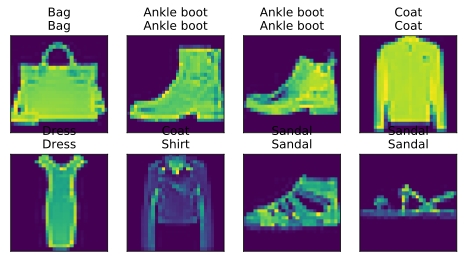

<Figure size 288x288 with 0 Axes>

In [35]:
X, y = iter(test_iter_torch).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net_torch(X).argmax(dim=1).numpy())
titles = [tr+"\n"+pred for tr,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

## softmax简洁实现

In [36]:
from torch import nn, optim
from torch.nn import init

In [37]:
train_iter_torch, test_iter_torch, batch_size

(<torch.utils.data.dataloader.DataLoader at 0x1beaa59ab48>,
 256)

### 定义模型

In [38]:
num_inputs, num_outputs

(784, 10)

#### 方法1

In [39]:
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    
    def forward(self,x):
        # x归一化为行向量,即flatten层
        return self.linear(X.view(x.shape[0],-1))

In [40]:
net1 = LinearNet(num_inputs, num_outputs) 

#### 方法2

In [41]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [42]:
from collections import OrderedDict
net2 = nn.Sequential(OrderedDict([
    ("flat", FlattenLayer()),
    ("lin", nn.Linear(num_inputs, num_outputs))
]))

### 模型参数初始化

In [43]:
init.normal_(net1.linear.weight,mean=0,std=0.01)
init.constant_(net1.linear.bias,val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [44]:
init.normal_(net2.lin.weight,mean=0,std=0.01)
init.constant_(net2.lin.bias,val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [45]:
net2[1], net2.lin

(Linear(in_features=784, out_features=10, bias=True),
 Linear(in_features=784, out_features=10, bias=True))

In [46]:
try:
    net2["lin"]
except:
    print("please use net2.lin")

please use net2.lin


### 定义损失函数

In [47]:
loss = nn.CrossEntropyLoss()

### 定义优化函数
**优化函数包含模型的参数。优化函数与模型要配套。**

In [48]:
optimizer1 = optim.SGD(net1.parameters(),lr=0.1)
optimizer2 = optim.SGD(net2.parameters(),lr=0.1)

### 训练模型

In [49]:
for epoch in range(1,num_epochs+1):
    train_l_sum, train_acc_sum,n = 0.0,0.0,0
    for X,y in train_iter_torch:
        y_hat = net1(X)
        l = loss(y_hat,y).sum()
        optimizer1.zero_grad()
        l.backward()
        optimizer1.step()
        
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
#     test_acc = evaluate_accuracy(test_iter_torch,net1)
    print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.4f}, test_acc {:.4f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, train_loss 0.0031, train_acc_sum 0.7489, test_acc 0.8253
epoch 2, train_loss 0.0022, train_acc_sum 0.8135, test_acc 0.8253
epoch 3, train_loss 0.0021, train_acc_sum 0.8253, test_acc 0.8253
epoch 4, train_loss 0.0020, train_acc_sum 0.8318, test_acc 0.8253
epoch 5, train_loss 0.0019, train_acc_sum 0.8377, test_acc 0.8253


In [50]:
for epoch in range(1,num_epochs+1):
    train_l_sum, train_acc_sum,n = 0.0,0.0,0
    for X,y in train_iter_torch:
        y_hat = net2(X)
        l = loss(y_hat,y).sum()
        optimizer2.zero_grad()
        l.backward()
        optimizer2.step()
        
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter_torch,net2)
    print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.4f}, test_acc {:.4f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, train_loss 0.0031, train_acc_sum 0.7468, test_acc 0.7885
epoch 2, train_loss 0.0022, train_acc_sum 0.8133, test_acc 0.8078
epoch 3, train_loss 0.0021, train_acc_sum 0.8265, test_acc 0.8139
epoch 4, train_loss 0.0020, train_acc_sum 0.8306, test_acc 0.8167
epoch 5, train_loss 0.0019, train_acc_sum 0.8367, test_acc 0.8213


### 模型预测

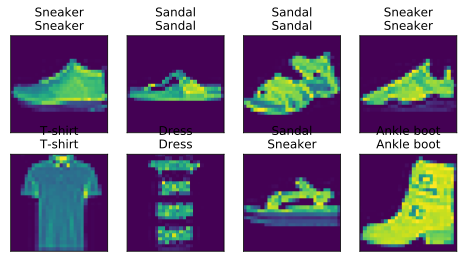

<Figure size 288x288 with 0 Axes>

In [51]:
X, y = iter(test_iter_torch).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net1(X).argmax(dim=1).numpy())
titles = [tr+"\n"+pred for tr,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

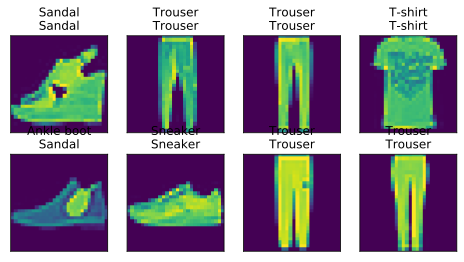

<Figure size 288x288 with 0 Axes>

In [52]:
X, y = iter(test_iter_torch).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net2(X).argmax(dim=1).numpy())
titles = [tr+"\n"+pred for tr,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])